In [ ]:
#First, we need to import the necessary libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
df = pd.read_csv('traffic.csv')


In [13]:
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [ ]:
#Next, we need to preprocess the dataset. Let's start by converting the 'DateTime' column to a datetime object and setting it as the index:

df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)


In [ ]:
#We also need to convert the 'Junction' and 'ID' columns to categorical variables:

df['Junction'] = df['Junction'].astype('category')
df['ID'] = df['ID'].astype('category')


In [ ]:
#Now, we can split the dataset into training and testing sets:

train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]


In [ ]:
#Next, we need to scale the data using MinMaxScaler:

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df['Vehicles'].values.reshape(-1, 1))
test_data = scaler.transform(test_df['Vehicles'].values.reshape(-1, 1))


In [ ]:
#We will create a function to prepare the data for the LSTM, CNN-LSTM, and GRU models. This function will take a time series dataset and a window size as input and return a tuple containing the features and target for the model:



def prepare_data(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y


In [ ]:
#We will use a window size of 24, which means we will use the data for the previous 24 hours to predict the traffic flow for the current hour.

#Now, we can prepare the data for the LSTM, CNN-LSTM, and GRU models:

window_size = 24
train_X, train_y = prepare_data(train_data, window_size)
test_X, test_y = prepare_data(test_data, window_size)


In [ ]:
#Let's create the LSTM model:

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))


In [ ]:
#Now, we can compile and fit the model:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=2)


Epoch 1/50
1203/1203 - 49s - loss: 0.0032 - 49s/epoch - 41ms/step
Epoch 2/50
1203/1203 - 42s - loss: 0.0014 - 42s/epoch - 35ms/step
Epoch 3/50
1203/1203 - 44s - loss: 0.0012 - 44s/epoch - 37ms/step
Epoch 4/50
1203/1203 - 42s - loss: 0.0011 - 42s/epoch - 35ms/step
Epoch 5/50
1203/1203 - 48s - loss: 0.0011 - 48s/epoch - 40ms/step
Epoch 6/50
1203/1203 - 42s - loss: 0.0011 - 42s/epoch - 35ms/step
Epoch 7/50
1203/1203 - 44s - loss: 0.0010 - 44s/epoch - 37ms/step
Epoch 8/50
1203/1203 - 42s - loss: 9.8831e-04 - 42s/epoch - 35ms/step
Epoch 9/50
1203/1203 - 43s - loss: 9.8578e-04 - 43s/epoch - 36ms/step
Epoch 10/50
1203/1203 - 42s - loss: 9.5976e-04 - 42s/epoch - 35ms/step
Epoch 11/50
1203/1203 - 42s - loss: 9.5495e-04 - 42s/epoch - 35ms/step
Epoch 12/50
1203/1203 - 43s - loss: 9.3714e-04 - 43s/epoch - 36ms/step
Epoch 13/50
1203/1203 - 42s - loss: 9.3170e-04 - 42s/epoch - 35ms/step
Epoch 14/50
1203/1203 - 42s - loss: 9.0560e-04 - 42s/epoch - 35ms/step
Epoch 15/50
1203/1203 - 43s - loss: 9.0423e

300/300 [==============================] - 4s 10ms/step


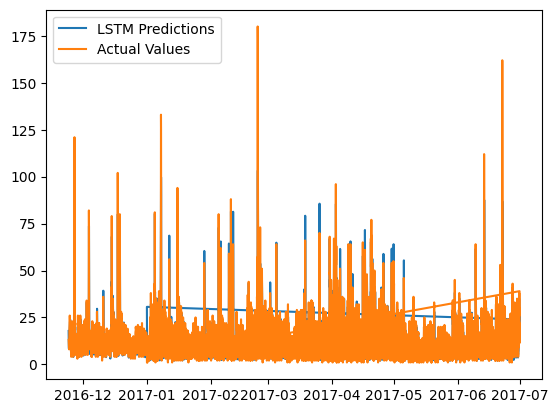

In [ ]:
#We can use the trained LSTM model to make predictions on the test data:

lstm_predictions = scaler.inverse_transform(lstm_model.predict(test_X))

# Plot the predictions
plt.plot(test_df.index[window_size:], lstm_predictions, label='LSTM Predictions')
plt.plot(test_df.index[window_size:], test_df['Vehicles'][window_size:], label='Actual Values')
plt.legend()
plt.show()


In [ ]:
#Now, let's evaluate the performance of the LSTM model using the evaluation metrics

lstm_mae = mean_absolute_error(test_df['Vehicles'][window_size:], lstm_predictions)
lstm_mse = mean_squared_error(test_df['Vehicles'][window_size:], lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(test_df['Vehicles'][window_size:], lstm_predictions)

print('LSTM MAE:', lstm_mae)
print('LSTM MSE:', lstm_mse)
print('LSTM RMSE:', lstm_rmse)
print('LSTM R2:', lstm_r2)


LSTM MAE: 2.698464534953237
LSTM MSE: 23.25814643696928
LSTM RMSE: 4.822670052675103
LSTM R2: 0.7649549859917393


Epoch 1/50
1203/1203 - 23s - loss: 0.0025 - 23s/epoch - 19ms/step
Epoch 2/50
1203/1203 - 18s - loss: 0.0012 - 18s/epoch - 15ms/step
Epoch 3/50
1203/1203 - 19s - loss: 0.0011 - 19s/epoch - 16ms/step
Epoch 4/50
1203/1203 - 18s - loss: 0.0010 - 18s/epoch - 15ms/step
Epoch 5/50
1203/1203 - 18s - loss: 0.0010 - 18s/epoch - 15ms/step
Epoch 6/50
1203/1203 - 19s - loss: 9.8024e-04 - 19s/epoch - 16ms/step
Epoch 7/50
1203/1203 - 18s - loss: 9.5743e-04 - 18s/epoch - 15ms/step
Epoch 8/50
1203/1203 - 19s - loss: 9.5224e-04 - 19s/epoch - 16ms/step
Epoch 9/50
1203/1203 - 18s - loss: 9.2291e-04 - 18s/epoch - 15ms/step
Epoch 10/50
1203/1203 - 19s - loss: 9.0982e-04 - 19s/epoch - 16ms/step
Epoch 11/50
1203/1203 - 18s - loss: 8.9971e-04 - 18s/epoch - 15ms/step
Epoch 12/50
1203/1203 - 19s - loss: 8.9236e-04 - 19s/epoch - 16ms/step
Epoch 13/50
1203/1203 - 18s - loss: 8.9278e-04 - 18s/epoch - 15ms/step
Epoch 14/50
1203/1203 - 19s - loss: 8.7528e-04 - 19s/epoch - 16ms/step
Epoch 15/50
1203/1203 - 18s - loss:

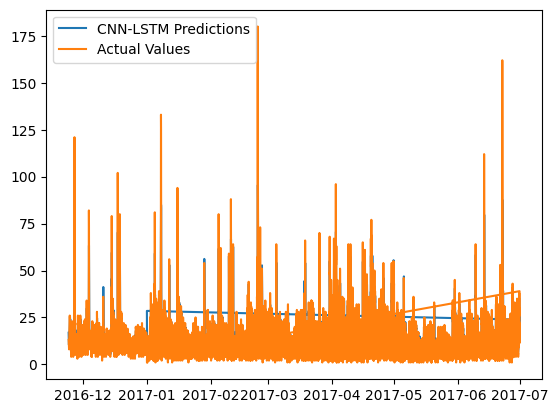

CNN-LSTM MAE: 2.6523734926680724
CNN-LSTM MSE: 23.197061085284577
CNN-LSTM RMSE: 4.816332742376151
CNN-LSTM R2: 0.7655723097918684


In [ ]:
#We can repeat the same process for the CNN-LSTM and GRU models. Here's the code for the CNN-LSTM model:

cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(64, 3, activation='relu', input_shape=(window_size, 1)))
cnn_lstm_model.add(Conv1D(64, 3, activation='relu'))
cnn_lstm_model.add(MaxPooling1D(2))
cnn_lstm_model.add(LSTM(50, return_sequences=True))
cnn_lstm_model.add(Dropout(0.2))
cnn_lstm_model.add(LSTM(50))
cnn_lstm_model.add(Dropout(0.2))
cnn_lstm_model.add(Dense(1))

cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
cnn_lstm_model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=2)

cnn_lstm_predictions = scaler.inverse_transform(cnn_lstm_model.predict(test_X))

plt.plot(test_df.index[window_size:], cnn_lstm_predictions, label='CNN-LSTM Predictions')
plt.plot(test_df.index[window_size:], test_df['Vehicles'][window_size:], label='Actual Values')
plt.legend()
plt.show()

cnn_lstm_mae = mean_absolute_error(test_df['Vehicles'][window_size:], cnn_lstm_predictions)
cnn_lstm_mse = mean_squared_error(test_df['Vehicles'][window_size:], cnn_lstm_predictions)
cnn_lstm_rmse = np.sqrt(cnn_lstm_mse)
cnn_lstm_r2 = r2_score(test_df['Vehicles'][window_size:], cnn_lstm_predictions)

print('CNN-LSTM MAE:', cnn_lstm_mae)
print('CNN-LSTM MSE:', cnn_lstm_mse)
print('CNN-LSTM RMSE:', cnn_lstm_rmse)
print('CNN-LSTM R2:', cnn_lstm_r2)


In [ ]:
#And here's the code for the GRU model:

gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(window_size, 1)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(50))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=2)

gru_predictions = scaler.inverse_transform(gru_model.predict(test_X))

plt.plot(test_df.index[window_size:], gru_predictions, label='GRU Predictions')
plt.plot(test_df.index[window_size:], test_df['Vehicles'][window_size:], label='Actual Values')
plt.legend()
plt.show()

gru_mae = mean_absolute_error(test_df['Vehicles'][window_size:], gru_predictions)
gru_mse = mean_squared_error(test_df['Vehicles'][window_size:], gru_predictions)
gru_rmse = np.sqrt(gru_mse)
gru_r2 = r2_score(test_df['Vehicles'][window_size:], gru_predictions)

print('GRU MAE:', gru_mae)
print('GRU MSE:', gru_mse)
print('GRU RMSE:', gru_rmse)
print('GRU R2:', gru_r2)


Epoch 1/50
1203/1203 - 50s - loss: 0.0020 - 50s/epoch - 42ms/step
Epoch 2/50
1203/1203 - 43s - loss: 0.0013 - 43s/epoch - 36ms/step
Epoch 3/50
1203/1203 - 44s - loss: 0.0012 - 44s/epoch - 37ms/step
Epoch 4/50
1203/1203 - 44s - loss: 0.0011 - 44s/epoch - 36ms/step
Epoch 5/50
1203/1203 - 45s - loss: 0.0011 - 45s/epoch - 38ms/step
Epoch 6/50
1203/1203 - 44s - loss: 0.0011 - 44s/epoch - 36ms/step
Epoch 7/50
1203/1203 - 44s - loss: 0.0010 - 44s/epoch - 37ms/step
Epoch 8/50
1203/1203 - 43s - loss: 0.0010 - 43s/epoch - 36ms/step
Epoch 9/50
1203/1203 - 44s - loss: 9.7193e-04 - 44s/epoch - 37ms/step
Epoch 10/50
1203/1203 - 44s - loss: 9.5741e-04 - 44s/epoch - 36ms/step
Epoch 11/50
1203/1203 - 45s - loss: 9.4371e-04 - 45s/epoch - 37ms/step
Epoch 12/50
1203/1203 - 43s - loss: 9.2018e-04 - 43s/epoch - 36ms/step
Epoch 13/50
1203/1203 - 45s - loss: 9.2622e-04 - 45s/epoch - 38ms/step
Epoch 14/50
1203/1203 - 43s - loss: 9.0680e-04 - 43s/epoch - 36ms/step
Epoch 15/50
1203/1203 - 45s - loss: 8.9843e-04 

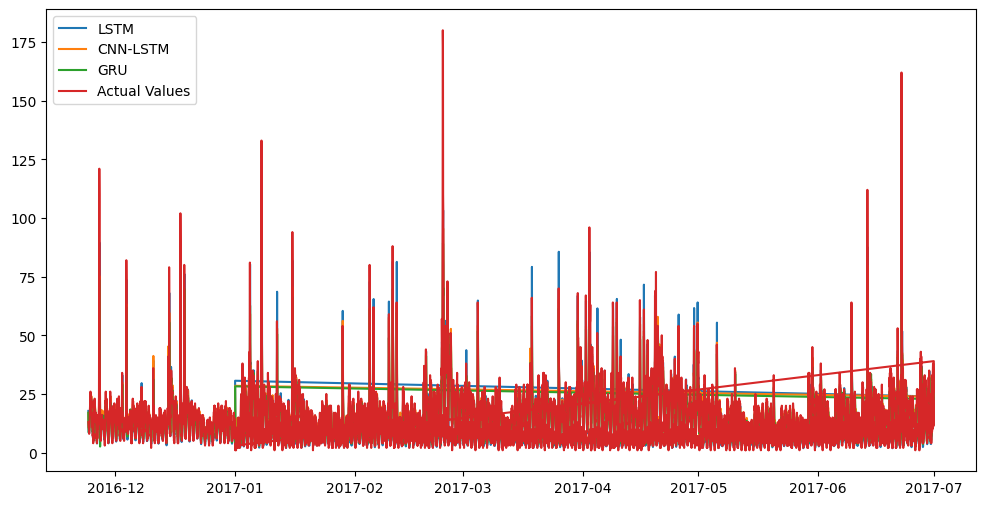

In [ ]:
#Finally, we can plot the results of all three models on the same graph to compare them

plt.figure(figsize=(12, 6))
plt.plot(test_df.index[window_size:], lstm_predictions, label='LSTM')
plt.plot(test_df.index[window_size:], cnn_lstm_predictions, label='CNN-LSTM')
plt.plot(test_df.index[window_size:], gru_predictions, label='GRU')
plt.plot(test_df.index[window_size:], test_df['Vehicles'][window_size:], label='Actual Values')
plt.legend()
plt.show()


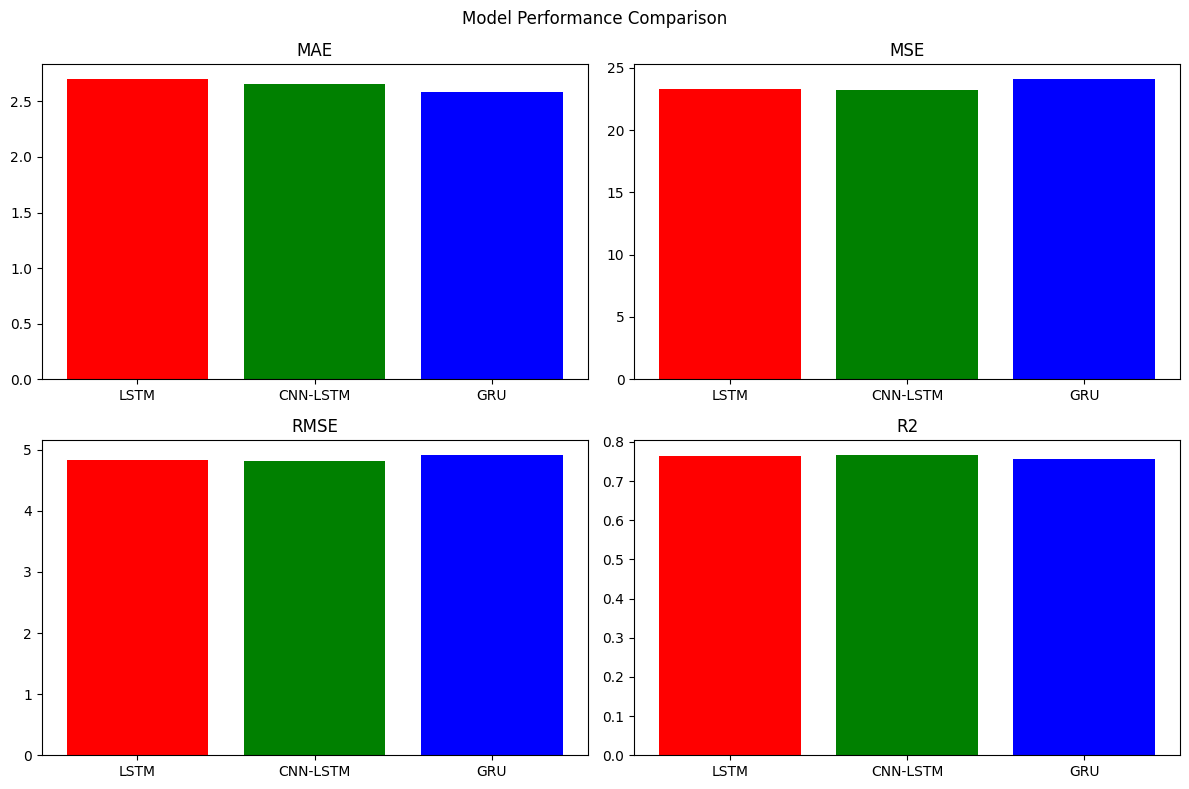

In [ ]:
import matplotlib.pyplot as plt

# Create lists of metric values for each model
lstm_metrics = [lstm_mae, lstm_mse, lstm_rmse, lstm_r2]
cnn_lstm_metrics = [cnn_lstm_mae, cnn_lstm_mse, cnn_lstm_rmse, cnn_lstm_r2]
gru_metrics = [gru_mae, gru_mse, gru_rmse, gru_r2]

# Create lists of model names and colors
model_names = ['LSTM', 'CNN-LSTM', 'GRU']
colors = ['r', 'g', 'b']

# Plot each metric for each model
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for i in range(4):
    row = i // 2
    col = i % 2
    ax[row][col].bar(model_names, [lstm_metrics[i], cnn_lstm_metrics[i], gru_metrics[i]], color=colors)
    ax[row][col].set_title(['MAE', 'MSE', 'RMSE', 'R2'][i])
plt.suptitle('Model Performance Comparison')
plt.tight_layout()
plt.show()


Processing Junction 1
91/91 [==============================] - 3s 10ms/step


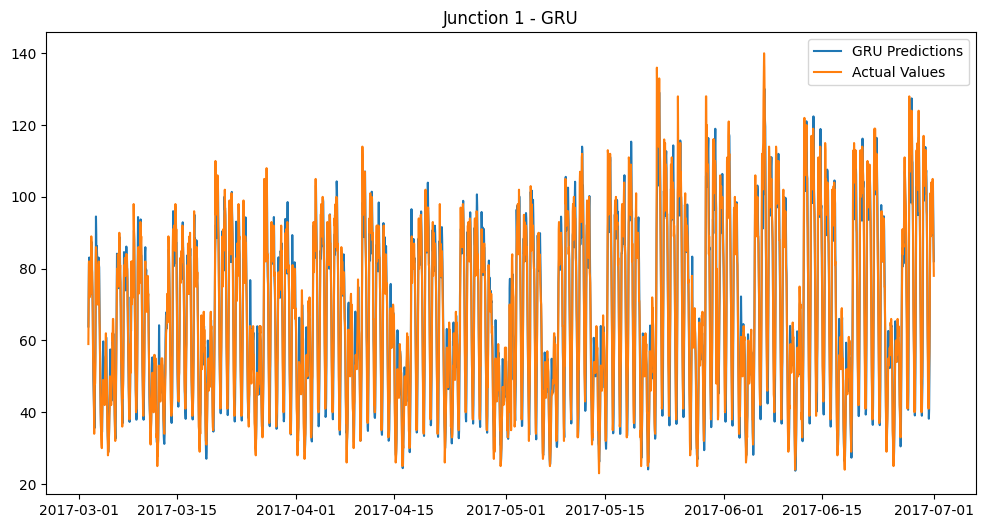

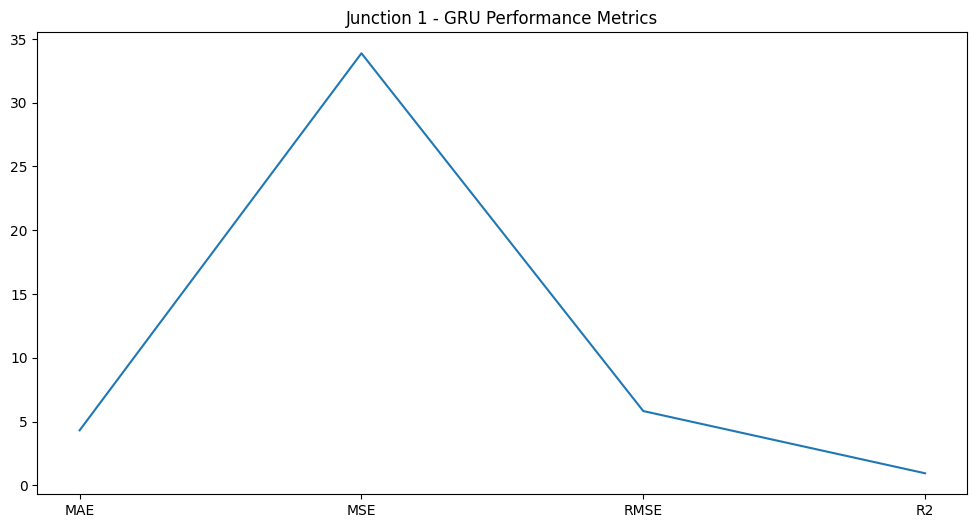

GRU MAE: 4.307624353069509
GRU MSE: 33.87904371806817
GRU RMSE: 5.8205707381723455
GRU R2: 0.9394894413942415
Processing Junction 2
91/91 [==============================] - 2s 11ms/step


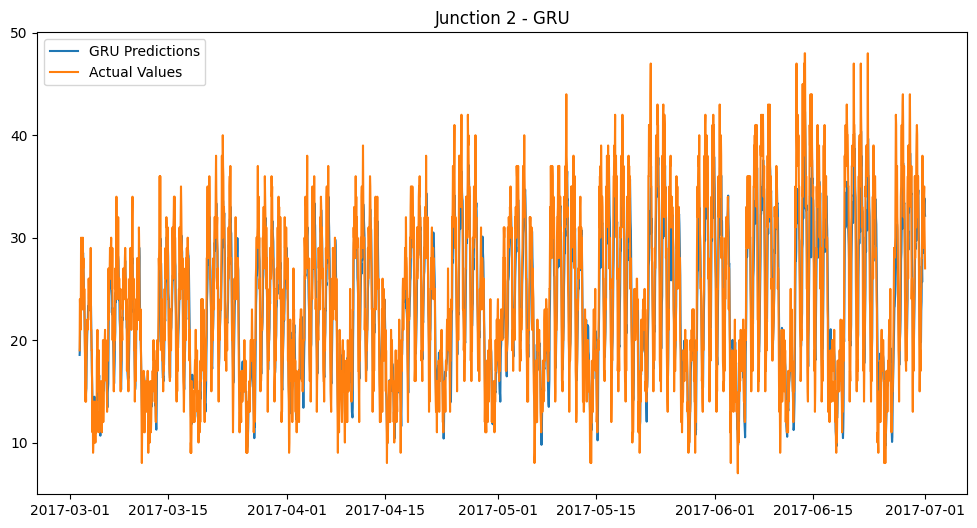

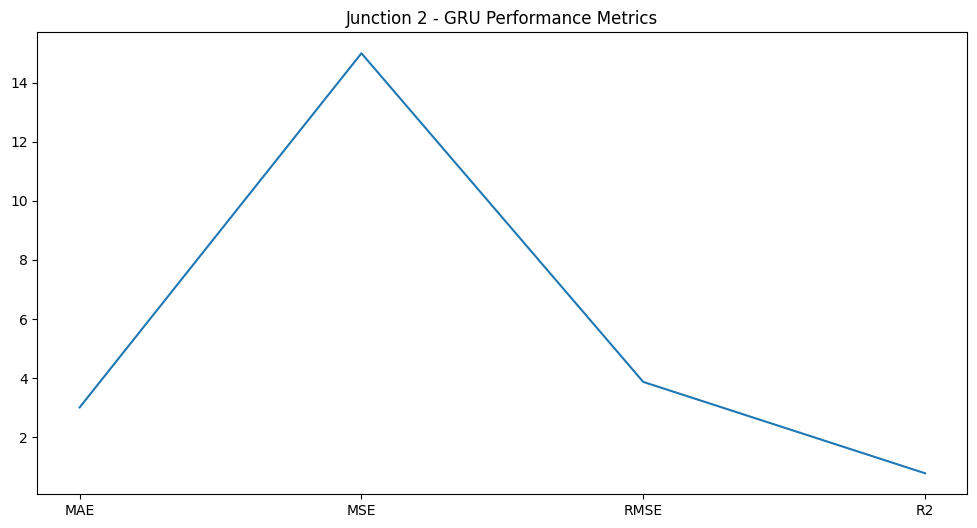

GRU MAE: 3.008484450028968
GRU MSE: 14.99082734117975
GRU RMSE: 3.8717989799548933
GRU R2: 0.7807402099366879
Processing Junction 3
91/91 [==============================] - 2s 12ms/step


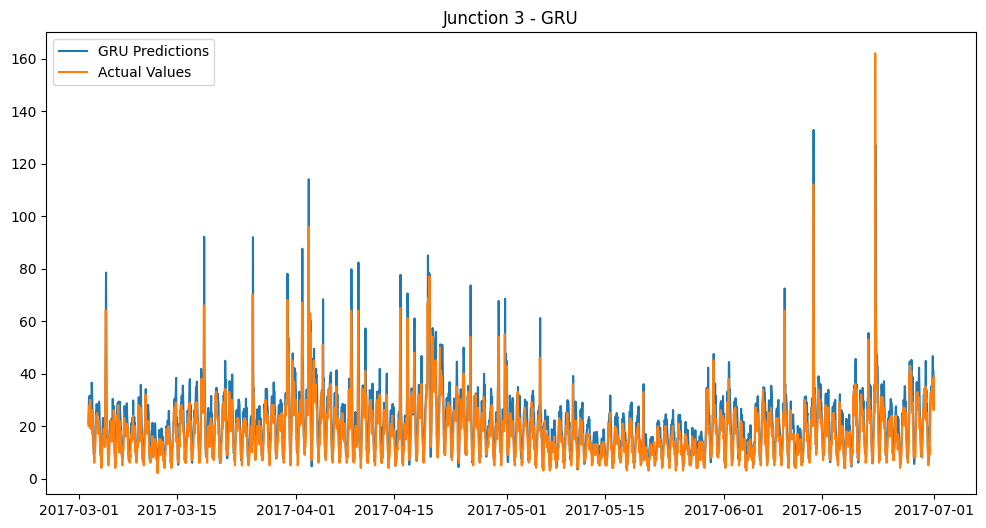

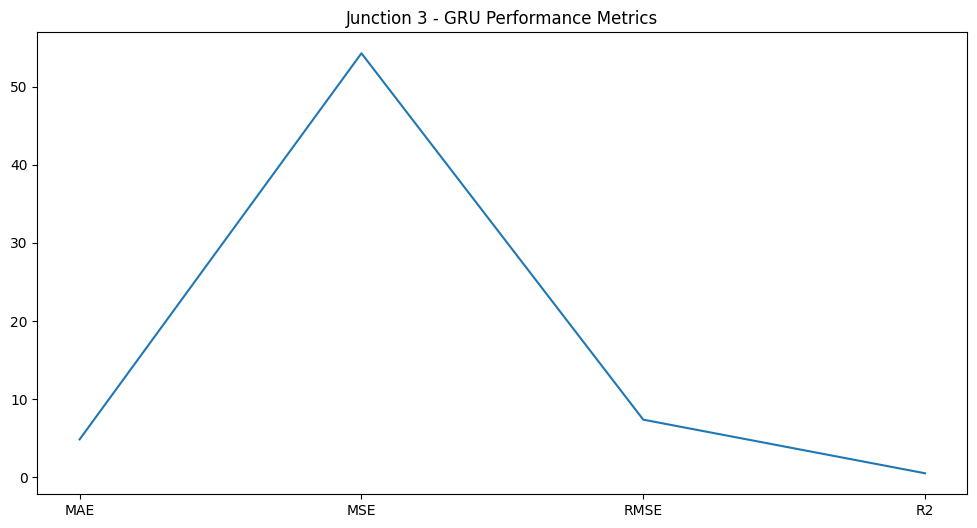

GRU MAE: 4.840552702592444
GRU MSE: 54.27951304519882
GRU RMSE: 7.367463134973858
GRU R2: 0.5024844253536442
Processing Junction 4
27/27 [==============================] - 1s 15ms/step


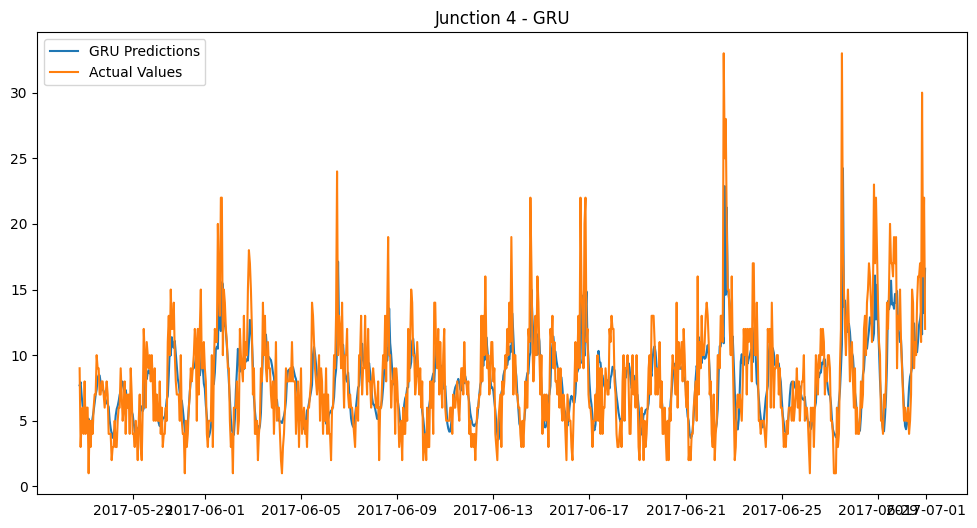

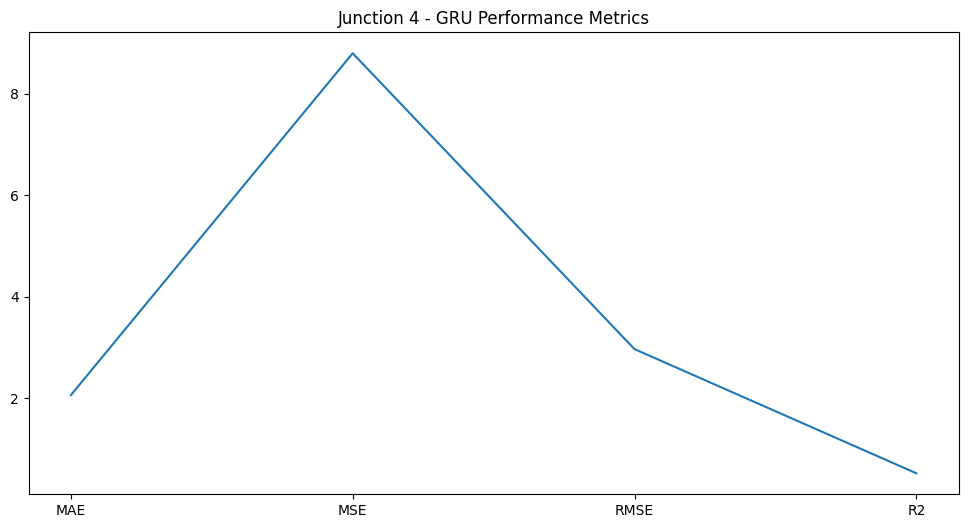

GRU MAE: 2.059084304267838
GRU MSE: 8.801297175275042
GRU RMSE: 2.96669802562968
GRU R2: 0.5179999006312471


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Read the data
df = pd.read_csv('traffic.csv')

# Convert the DateTime column to datetime object and set it as the index
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# Loop over each junction
for junction in df['Junction'].unique():
    print(f"Processing Junction {junction}")

    # Select data for the current junction
    junction_df = df[df['Junction'] == junction].copy()

    # Convert the ID column to categorical variable
    junction_df['ID'] = junction_df['ID'].astype('category')

    # Split the dataset into training and testing sets
    train_size = int(len(junction_df) * 0.8)
    train_df = junction_df.iloc[:train_size]
    test_df = junction_df.iloc[train_size:]

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_df['Vehicles'].values.reshape(-1, 1))
    test_data = scaler.transform(test_df['Vehicles'].values.reshape(-1, 1))

    # Prepare the data for the LSTM, CNN-LSTM, and GRU models
    window_size = 24
    train_X, train_y = prepare_data(train_data, window_size)
    test_X, test_y = prepare_data(test_data, window_size)

    # Create and train the GRU model
    gru_model = Sequential()
    gru_model.add(GRU(50, return_sequences=True, input_shape=(window_size, 1)))
    gru_model.add(Dropout(0.2))
    gru_model.add(GRU(50, return_sequences=True))
    gru_model.add(Dropout(0.2))
    gru_model.add(GRU(50))
    gru_model.add(Dropout(0.2))
    gru_model.add(Dense(1))
    gru_model.compile(optimizer='adam', loss='mean_squared_error')
    gru_model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)

    # Use the trained GRU model to make predictions on the test data
    gru_predictions = scaler.inverse_transform(gru_model.predict(test_X))

    # Evaluate the performance of the GRU model
    gru_mae = mean_absolute_error(test_df['Vehicles'][window_size:], gru_predictions)
    gru_mse = mean_squared_error(test_df['Vehicles'][window_size:], gru_predictions)
    gru_rmse = np.sqrt(gru_mse)
    gru_r2 = r2_score(test_df['Vehicles'][window_size:], gru_predictions)

    # Plot the predictions
    plt.figure(figsize=(12, 6))
    plt.plot(test_df.index[window_size:], gru_predictions, label='GRU Predictions')
    plt.plot(test_df.index[window_size:], test_df['Vehicles'][window_size:], label='Actual Values')
    plt.title(f"Junction {junction} - GRU")
    plt.legend()
    plt.show()

    # Plot MAE, MSE, RMSE, and R2
    plt.figure(figsize=(12, 6))
    plt.plot(['MAE', 'MSE', 'RMSE', 'R2'], [gru_mae, gru_mse, gru_rmse, gru_r2])
    plt.title(f"Junction {junction} - GRU Performance Metrics")
    plt.show()
    
    print('GRU MAE:', gru_mae)
    print('GRU MSE:', gru_mse)
    print('GRU RMSE:', gru_rmse)
    print('GRU R2:', gru_r2)

    
    


Processing Junction 1
91/91 [==============================] - 3s 15ms/step


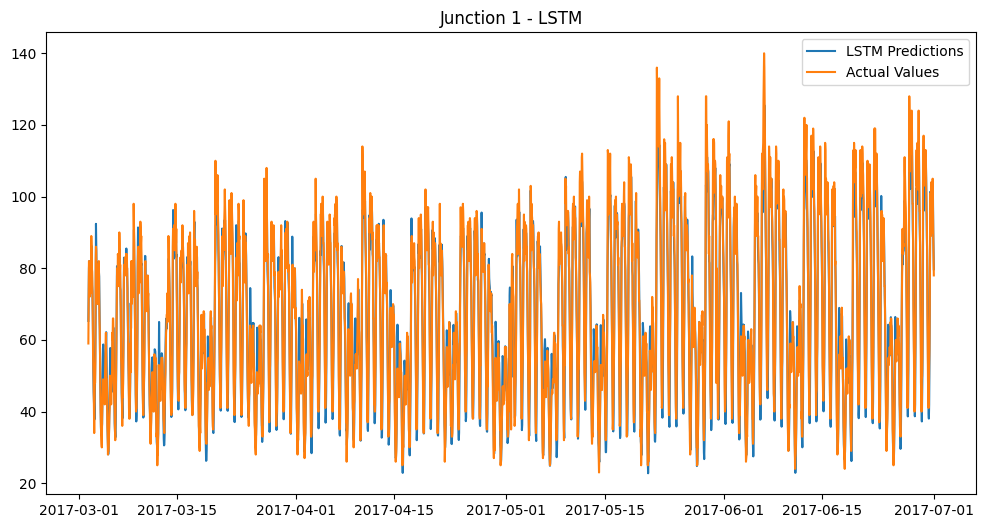

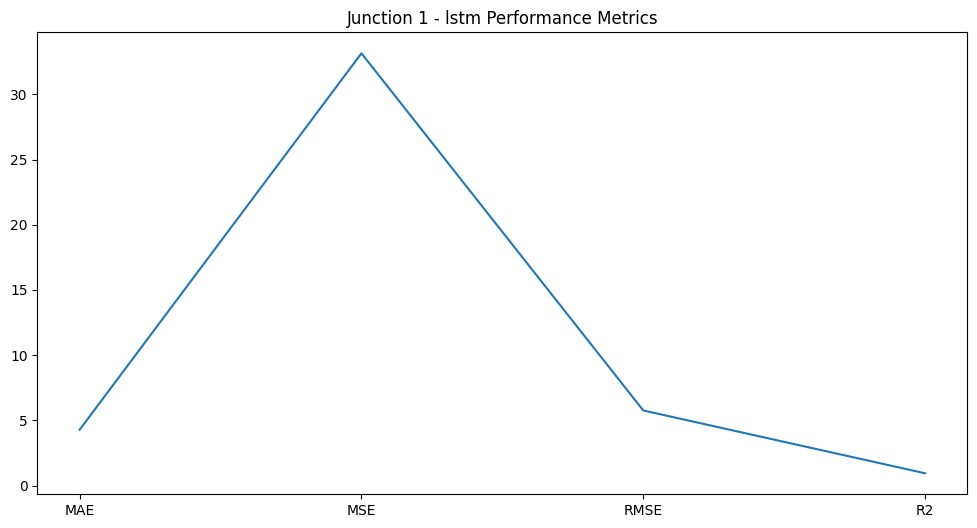

lstm MAE: 4.277726876715098
lstm MSE: 33.146182515609
lstm RMSE: 5.7572721418749175
lstm R2: 0.9407983874527645
Processing Junction 2
91/91 [==============================] - 3s 16ms/step


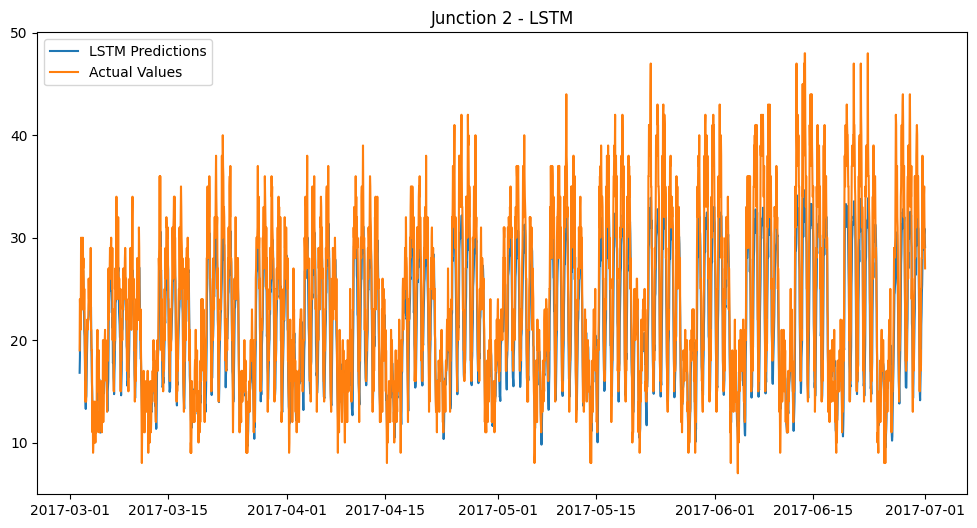

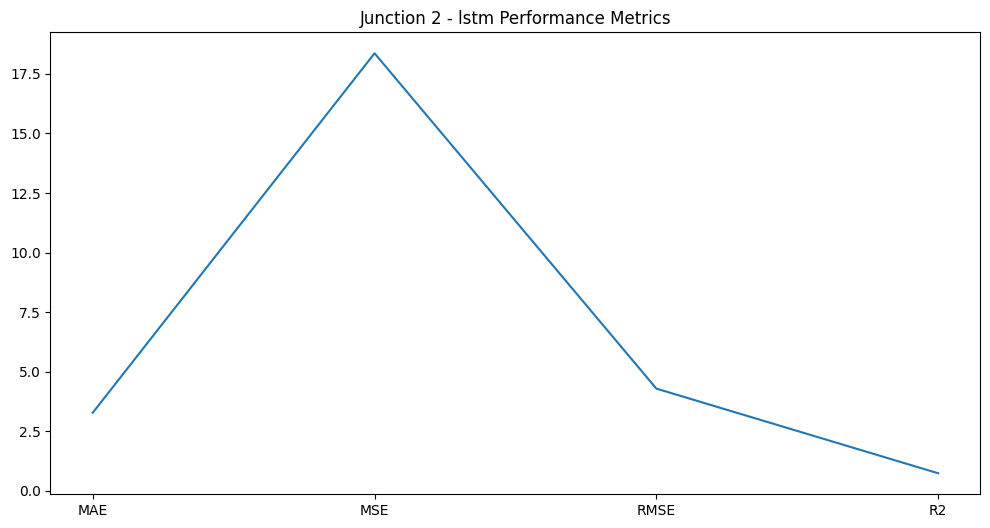

lstm MAE: 3.272241630290662
lstm MSE: 18.3639397430413
lstm RMSE: 4.28531676110895
lstm R2: 0.7314041792921036
Processing Junction 3
91/91 [==============================] - 3s 15ms/step


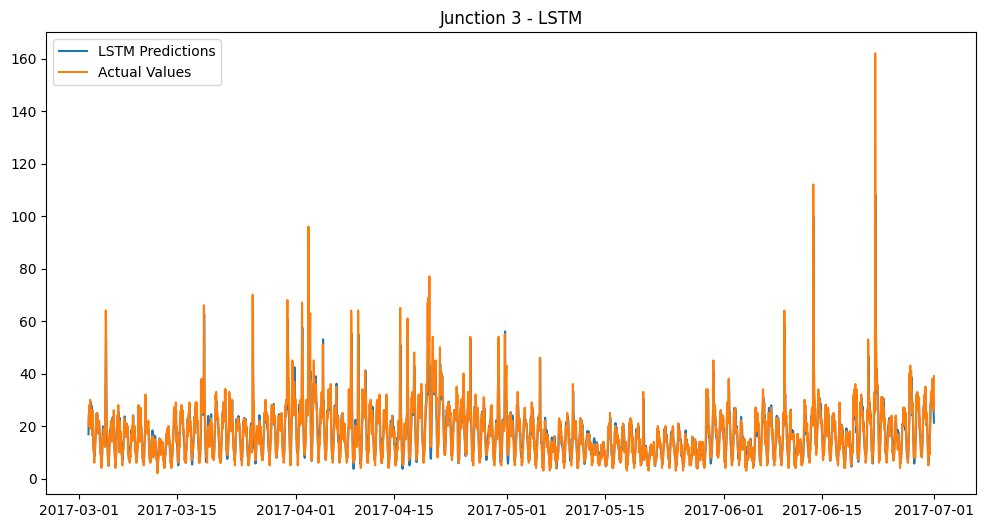

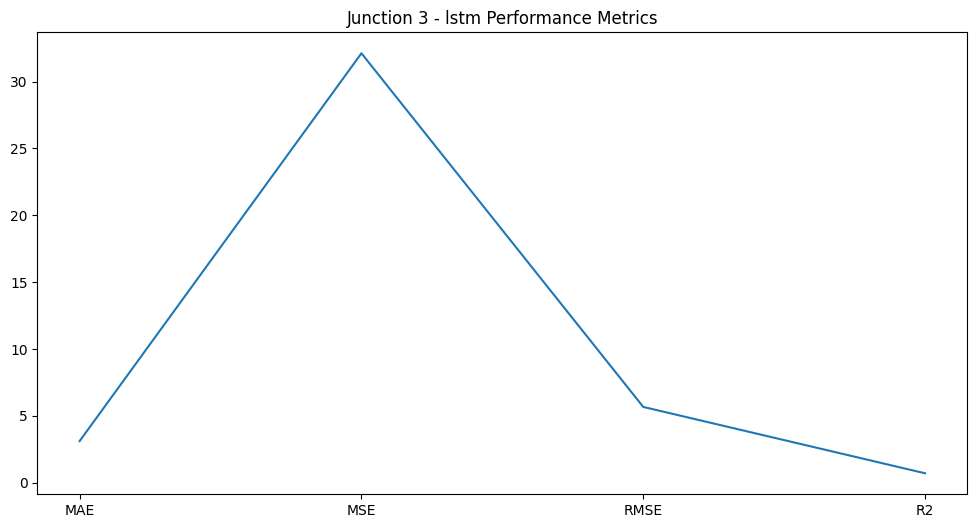

lstm MAE: 3.1136410105413725
lstm MSE: 32.11542255169256
lstm RMSE: 5.6670470751258595
lstm R2: 0.7056362150391629
Processing Junction 4
27/27 [==============================] - 2s 14ms/step


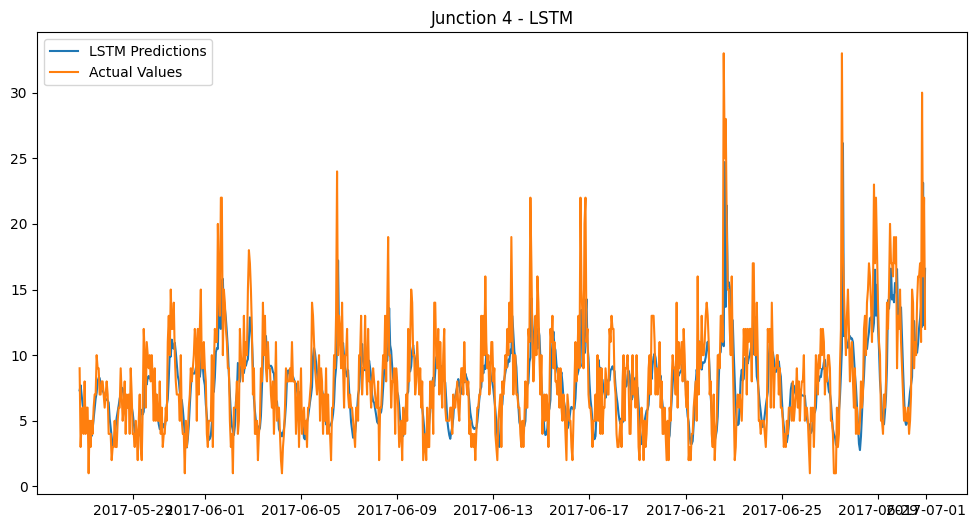

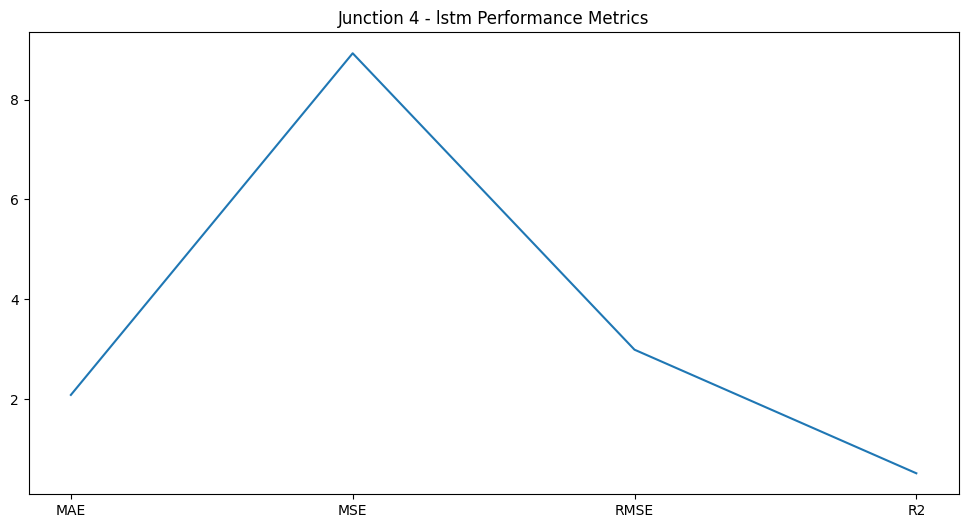

lstm MAE: 2.081624233652149
lstm MSE: 8.930351608332717
lstm RMSE: 2.9883693895388364
lstm R2: 0.510932277720783


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Read the data
df = pd.read_csv('traffic.csv')

# Convert the DateTime column to datetime object and set it as the index
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# Loop over each junction
for junction in df['Junction'].unique():
    print(f"Processing Junction {junction}")

    # Select data for the current junction
    junction_df = df[df['Junction'] == junction].copy()

    # Convert the ID column to categorical variable
    junction_df['ID'] = junction_df['ID'].astype('category')

    # Split the dataset into training and testing sets
    train_size = int(len(junction_df) * 0.8)
    train_df = junction_df.iloc[:train_size]
    test_df = junction_df.iloc[train_size:]

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_df['Vehicles'].values.reshape(-1, 1))
    test_data = scaler.transform(test_df['Vehicles'].values.reshape(-1, 1))

    # Prepare the data for the LSTM, CNN-LSTM, and GRU models
    window_size = 24
    train_X, train_y = prepare_data(train_data, window_size)
    test_X, test_y = prepare_data(test_data, window_size)

    # Create and train the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(50, return_sequences=True))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(50))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    lstm_model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)

    # Use the trained LSTM model to make predictions on the test data
    lstm_predictions = scaler.inverse_transform(lstm_model.predict(test_X))

    # Evaluate the performance of the LSTM model
    lstm_mae = mean_absolute_error(test_df['Vehicles'][window_size:], lstm_predictions)
    lstm_mse = mean_squared_error(test_df['Vehicles'][window_size:], lstm_predictions)
    lstm_rmse = np.sqrt(lstm_mse)
    lstm_r2 = r2_score(test_df['Vehicles'][window_size:], lstm_predictions)

    # Plot the predictions
    plt.figure(figsize=(12, 6))
    plt.plot(test_df.index[window_size:], lstm_predictions, label='LSTM Predictions')
    plt.plot(test_df.index[window_size:], test_df['Vehicles'][window_size:], label='Actual Values')
    plt.title(f"Junction {junction} - LSTM")
    plt.legend()
    plt.show()
    
    # Plot MAE, MSE, RMSE, and R2
    plt.figure(figsize=(12, 6))
    plt.plot(['MAE', 'MSE', 'RMSE', 'R2'], [lstm_mae, lstm_mse, lstm_rmse, lstm_r2])
    plt.title(f"Junction {junction} - lstm Performance Metrics")
    plt.show()
    
    print('lstm MAE:', lstm_mae)
    print('lstm MSE:', lstm_mse)
    print('lstm RMSE:', lstm_rmse)
    print('lstm R2:', lstm_r2)


Processing Junction 1
91/91 [==============================] - 2s 8ms/step


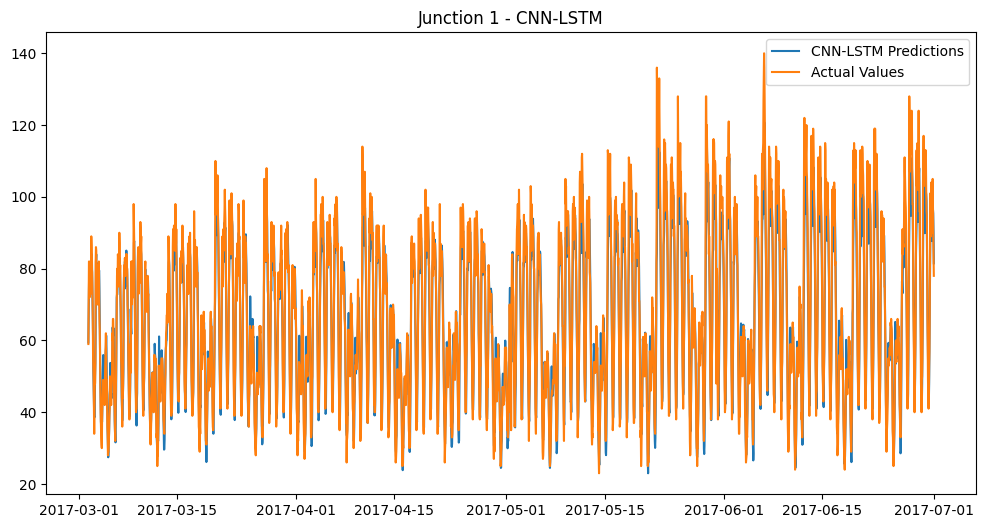

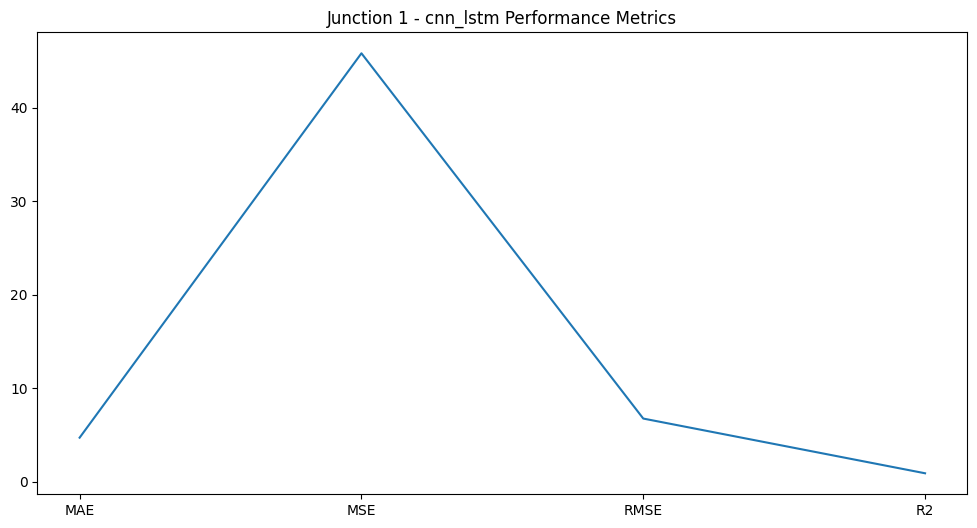

cnn_lstm MAE: 4.725922636911659
cnn_lstm MSE: 45.83285221827452
cnn_lstm RMSE: 6.769996471068099
cnn_lstm R2: 0.9181390267888851
Processing Junction 2
91/91 [==============================] - 2s 7ms/step


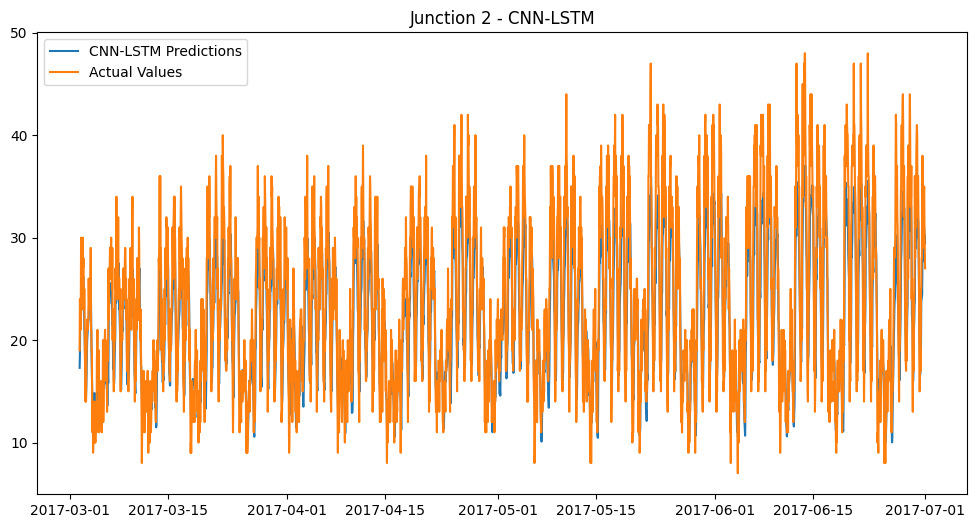

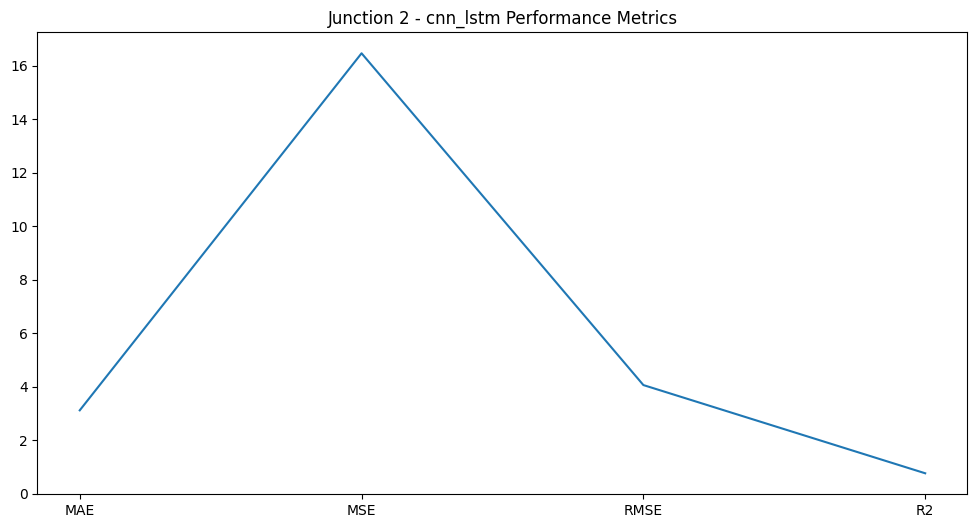

cnn_lstm MAE: 3.113054591098186
cnn_lstm MSE: 16.464321697586673
cnn_lstm RMSE: 4.057625130243881
cnn_lstm R2: 0.7591884932840811
Processing Junction 3
91/91 [==============================] - 2s 9ms/step


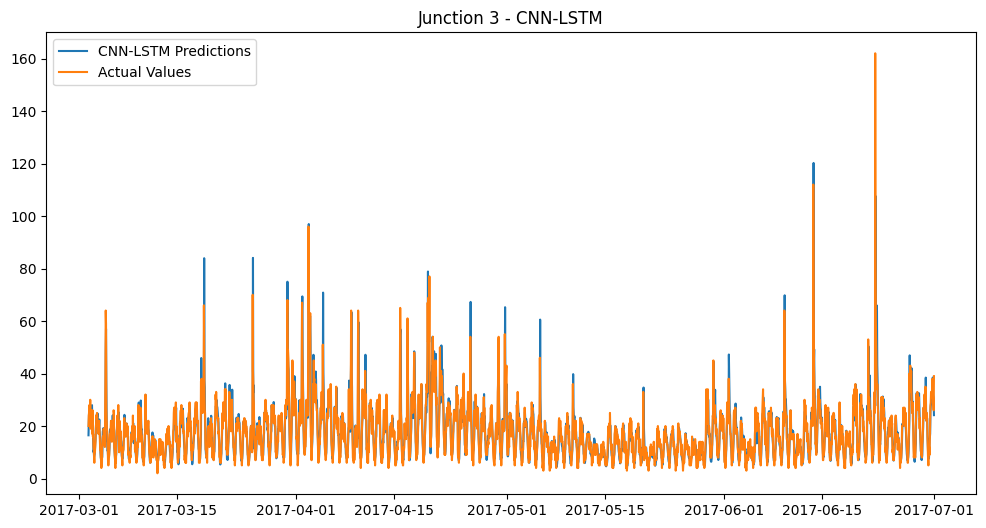

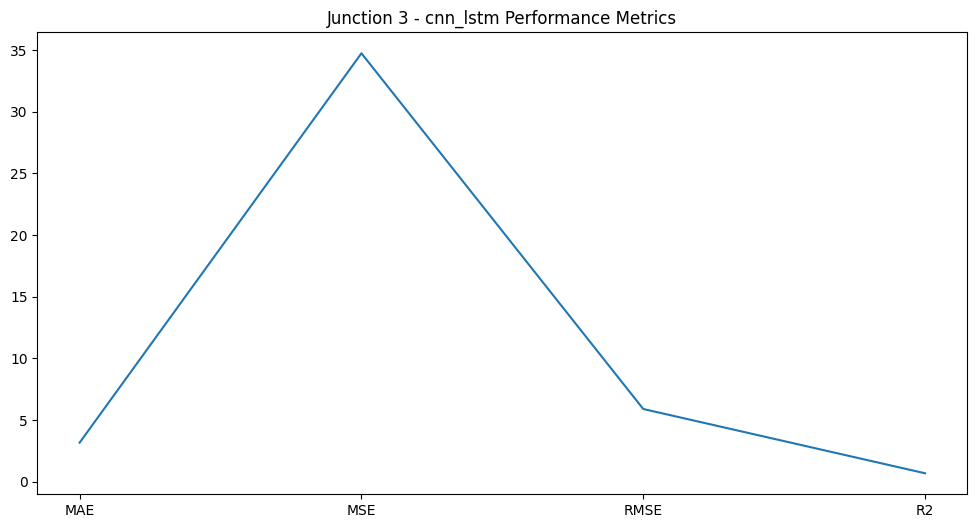

cnn_lstm MAE: 3.1627186432609493
cnn_lstm MSE: 34.74303708389764
cnn_lstm RMSE: 5.894322444852983
cnn_lstm R2: 0.6815520057196993
Processing Junction 4
27/27 [==============================] - 1s 8ms/step


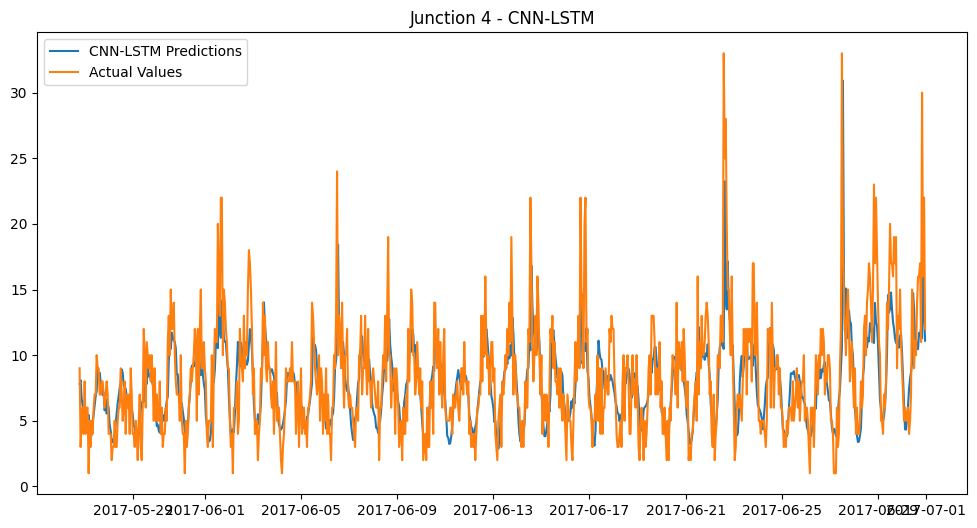

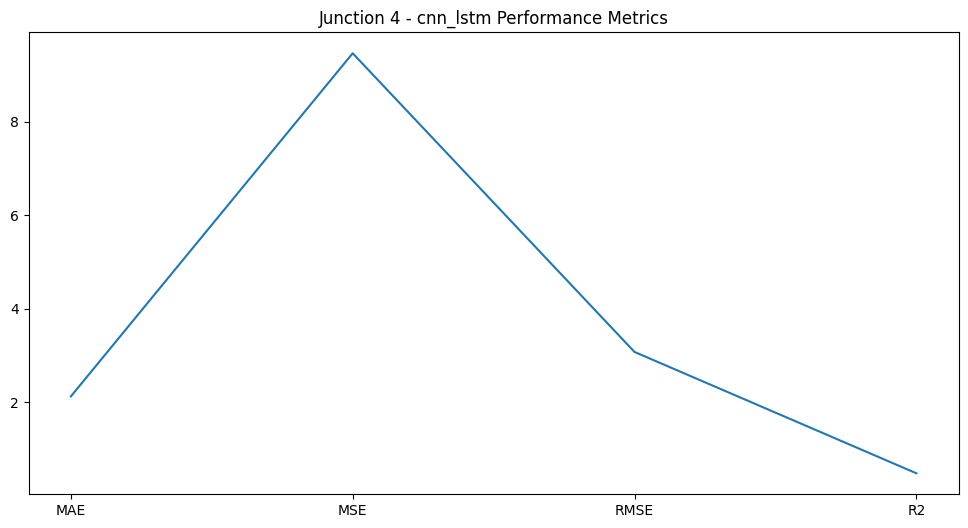

cnn_lstm MAE: 2.125753875879141
cnn_lstm MSE: 9.462998307694765
cnn_lstm RMSE: 3.0761986781894897
cnn_lstm R2: 0.48176205918274995


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Read the data
df = pd.read_csv('traffic.csv')

# Convert the DateTime column to datetime object and set it as the index
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# Loop over each junction
for junction in df['Junction'].unique():
    print(f"Processing Junction {junction}")

    # Select data for the current junction
    junction_df = df[df['Junction'] == junction].copy()

    # Convert the ID column to categorical variable
    junction_df['ID'] = junction_df['ID'].astype('category')

    # Split the dataset into training and testing sets
    train_size = int(len(junction_df) * 0.8)
    train_df = junction_df.iloc[:train_size]
    test_df = junction_df.iloc[train_size:]

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_df['Vehicles'].values.reshape(-1, 1))
    test_data = scaler.transform(test_df['Vehicles'].values.reshape(-1, 1))

    # Prepare the data for the LSTM, CNN-LSTM, and GRU models
    window_size = 24
    train_X, train_y = prepare_data(train_data, window_size)
    test_X, test_y = prepare_data(test_data, window_size)


    # Create and train the CNN-LSTM model
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(LSTM(50, return_sequences=True))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(LSTM(50))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Dense(1))
    cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    cnn_lstm_model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)

    # Use the trained CNN-LSTM model to make predictions on the test data
    cnn_lstm_predictions = scaler.inverse_transform(cnn_lstm_model.predict(test_X))

    # Evaluate the performance of the CNN-LSTM model
    cnn_lstm_mae = mean_absolute_error(test_df['Vehicles'][window_size:], cnn_lstm_predictions)
    cnn_lstm_mse = mean_squared_error(test_df['Vehicles'][window_size:], cnn_lstm_predictions)
    cnn_lstm_rmse = np.sqrt(cnn_lstm_mse)
    cnn_lstm_r2 = r2_score(test_df['Vehicles'][window_size:], cnn_lstm_predictions)

    # Plot the predictions
    plt.figure(figsize=(12, 6))
    plt.plot(test_df.index[window_size:], cnn_lstm_predictions, label='CNN-LSTM Predictions')
    plt.plot(test_df.index[window_size:], test_df['Vehicles'][window_size:], label='Actual Values')
    plt.title(f"Junction {junction} - CNN-LSTM")
    plt.legend()
    plt.show()

     # Plot MAE, MSE, RMSE, and R2
    plt.figure(figsize=(12, 6))
    plt.plot(['MAE', 'MSE', 'RMSE', 'R2'], [cnn_lstm_mae, cnn_lstm_mse, cnn_lstm_rmse, cnn_lstm_r2])
    plt.title(f"Junction {junction} - cnn_lstm Performance Metrics")
    plt.show()
    
    print('cnn_lstm MAE:', cnn_lstm_mae)
    print('cnn_lstm MSE:', cnn_lstm_mse)
    print('cnn_lstm RMSE:', cnn_lstm_rmse)
    print('cnn_lstm R2:', cnn_lstm_r2)
